In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import statsmodels.formula.api as smf


os.chdir("/Users/alyssanguyen/Desktop/spatial_econ_pset2")

In [23]:
panel = pd.read_csv("state_panel.csv")

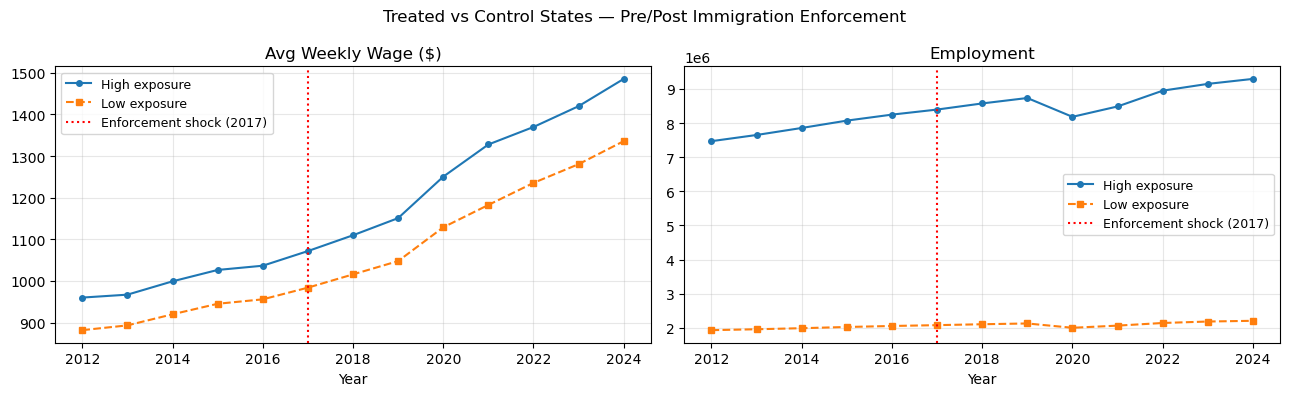

In [24]:
# ──DiD preview: treated vs control wage growth ────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

for ax, var, label in zip(axes,
                           ["avg_weekly_wage", "employment"],
                           ["Avg Weekly Wage ($)", "Employment"]):
    for grp, style in [(1, "-o"), (0, "--s")]:
        sub = panel[panel["high_exposure"] == grp]
        grp_mean = sub.groupby("year")[var].mean()
        ax.plot(grp_mean.index, grp_mean.values, style,
                label="High exposure" if grp == 1 else "Low exposure",
                markersize=4)
    ax.axvline(2017, color="red", linestyle=":", linewidth=1.5, label="Enforcement shock (2017)")
    ax.set_title(label)
    ax.set_xlabel("Year")
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle("Treated vs Control States — Pre/Post Immigration Enforcement", fontsize=12)
plt.tight_layout()
plt.savefig("did_preview.png", dpi=150, bbox_inches="tight")
plt.show()

## Data Preprocessing

In [51]:
panel_raw = pd.read_csv("state_panel.csv", dtype={"state_fips": str})
mig_raw   = pd.read_csv("state_migration_annual.csv", dtype={"origin_fips": str,
                                                               "dest_fips": str})
mu_raw    = pd.read_csv("mu_minus1.csv", index_col=0, dtype=str)

YEARS    = list(range(2013, 2022)) # 2013-2021  (migration through 2021, w_hat needs 2012)
SIM_FROM = 2013 # first simulation year
SHOCK_YR = 2017 # enforcement begins
ANTICIP_YR = 2015 # agents anticipate from here (CF2)

panel = panel_raw[panel_raw["year"].isin([2012] + YEARS)].copy()
panel["state_fips"] = panel["state_fips"].str.zfill(2)

# Recompute w_hat cleanly as a percent change in wage from the previous year, by state
panel = panel.sort_values(["state_fips", "year"])
panel["w_hat"] = panel.groupby("state_fips")["avg_weekly_wage"].transform(
    lambda x: x / x.shift(1)
)

# sample is 2013 onwards 
analysis = panel[panel["year"].isin(YEARS)].copy()

print(f"Analysis panel: {analysis.shape[0]} rows | "
      f"{analysis['state_fips'].nunique()} states | "
      f"years {analysis['year'].min()}–{analysis['year'].max()}")
print(f"\nHigh-exposure states: "
      f"{sorted(analysis[analysis['high_exposure']==1]['state_abbr'].unique())}")
print(f"Range of percent changes in wage to the next year: {analysis['w_hat'].min():.3f} – {analysis['w_hat'].max():.3f}")

Analysis panel: 459 rows | 51 states | years 2013–2021

High-exposure states: ['AZ', 'CA', 'FL', 'NM', 'NY', 'TX']
Range of percent changes in wage to the next year: 0.964 – 1.114


# Reduced-Form DiD — Two-Way Fixed Effects

In [52]:
reg = analysis.copy()
reg["log_wage"]   = np.log(reg["avg_weekly_wage"])
reg["log_empl"]   = np.log(reg["employment"])
reg["state_fips"] = reg["state_fips"].astype("category")
reg["year_cat"]   = reg["year"].astype("category")

# ── Main specification: log(wage) ~ state_FE + year_FE + β·shock ─────────────
fit_wage = smf.ols(
    "log_wage ~ shock + C(state_fips) + C(year_cat)",
    data=reg
).fit(cov_type="cluster", cov_kwds={"groups": reg["state_fips"]})

fit_empl = smf.ols(
    "log_empl ~ shock + C(state_fips) + C(year_cat)",
    data=reg
).fit(cov_type="cluster", cov_kwds={"groups": reg["state_fips"]})

print("=== Two-Way FE DiD ===\n")
for label, fit, units in [("log(Avg Weekly Wage)", fit_wage, "%"),
                           ("log(Employment)",     fit_empl, "%")]:
    b  = fit.params["shock"]
    se = fit.bse["shock"]
    p  = fit.pvalues["shock"]
    stars = "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.1 else ""))
    print(f"  Outcome: {label}")
    print(f"    β (shock)  = {b:.4f}{stars}  (se={se:.4f}, p={p:.3f})")
    print(f"    Interpretation: {b*100:.2f}{units} effect on {label.split('(')[1].rstrip(')')}")
    print(f"    N={fit.nobs:.0f}  R²={fit.rsquared:.3f}\n")

=== Two-Way FE DiD ===

  Outcome: log(Avg Weekly Wage)
    β (shock)  = 0.0138  (se=0.0126, p=0.274)
    Interpretation: 1.38% effect on Avg Weekly Wage
    N=459  R²=0.990

  Outcome: log(Employment)
    β (shock)  = 0.0322**  (se=0.0161, p=0.046)
    Interpretation: 3.22% effect on Employment
    N=459  R²=0.999



Event study regression: log_wage ~ D_2013 + D_2014 + D_2015 + D_2017 + D_2018 + D_2019 + D_2020 + D_2021 + state_FE + year_FE


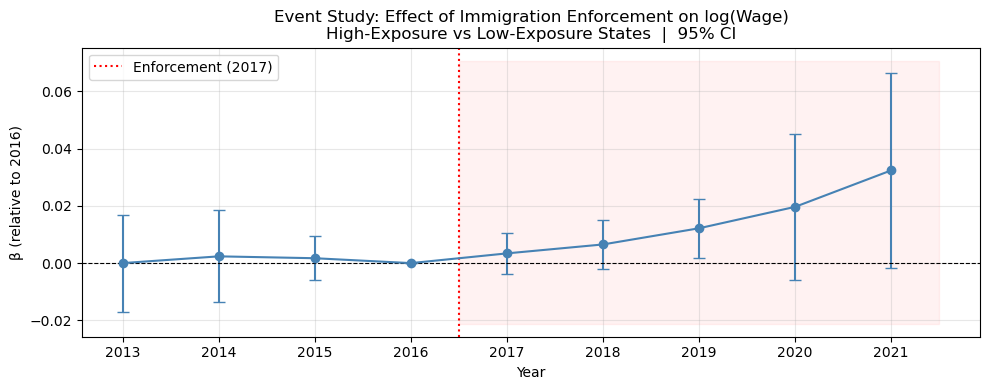

Pre-2017 coefficients near zero → parallel trends plausible


In [53]:
#Event study for parallel trends and dynamic effects

base_year = 2016
years_event = [y for y in YEARS if y != base_year]

for y in years_event:
    reg[f"D_{y}"] = ((reg["year"] == y) & (reg["high_exposure"] == 1)).astype(int)

event_terms = " + ".join([f"D_{y}" for y in years_event])

print(f"Event study regression: log_wage ~ {event_terms} + state_FE + year_FE")

fit_event = smf.ols(
    f"log_wage ~ {event_terms} + C(state_fips) + C(year_cat)",
    data=reg
).fit(cov_type="cluster", cov_kwds={"groups": reg["state_fips"]})

# Plot event study
coefs = {y: (fit_event.params.get(f"D_{y}", 0),
             fit_event.bse.get(f"D_{y}", 0))
         for y in years_event}
coefs[base_year] = (0.0, 0.0)     

ys = sorted(coefs.keys())
bs = [coefs[y][0] for y in ys]
ses = [coefs[y][1] for y in ys]

fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(ys, bs, yerr=[1.96 * s for s in ses],
            fmt="-o", color="steelblue", capsize=4, linewidth=1.5)
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
ax.axvline(SHOCK_YR - 0.5, color="red", linewidth=1.5,
           linestyle=":", label="Enforcement (2017)")
ax.fill_between([SHOCK_YR - 0.5, max(ys) + 0.5], ax.get_ylim()[0],
                ax.get_ylim()[1], alpha=0.05, color="red")
ax.set_xticks(ys)
ax.set_xlabel("Year")
ax.set_ylabel("β (relative to 2016)")
ax.set_title("Event Study: Effect of Immigration Enforcement on log(Wage)\n"
             "High-Exposure vs Low-Exposure States  |  95% CI")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("event_study.png", dpi=150, bbox_inches="tight")
plt.show()
print("Pre-2017 coefficients near zero → parallel trends plausible"
      if all(abs(coefs[y][0]) < 2*coefs[y][1] for y in YEARS if y < SHOCK_YR and y != base_year)
      else "WARNING: pre-trend detected — check parallel trends assumption")

## Parameter Calibration and Building Market Index

In [79]:
""""
This code block builds the initial transition matrix (μ) and calculates the average prob of staying and leaving a state. 
It loads the μ matrix from a CSV, ensures it's row-stochastic, and calibrates the migration sensitivity (ν) and discount factor (β) based on 
the literature.
It also identifies high-exposure states based on their FIPS codes for later use in the simulation.
"""
mu_raw.index   = mu_raw.index.astype(str).str.strip().str.zfill(2)
mu_raw.columns = mu_raw.columns.astype(str).str.strip().str.zfill(2)

mu0    = mu_raw.astype(float).values
states = list(mu_raw.index)
M      = len(states)
state_to_idx = {s: i for i, s in enumerate(states)}

print(f"mu0 shape: {mu0.shape}  |  sample states: {states[:5]} ... {states[-3:]}")
assert np.allclose(mu0.sum(axis=1), 1.0, atol=1e-6), "mu0 is not row-stochastic!"
print("Row-stochastic: OK")

#Calibrating ν  
avg_stay = np.diag(mu0).mean()
avg_move = 1 - avg_stay
print(f"\nAvg stay prob : {avg_stay:.4f}")
print(f"Avg move prob : {avg_move:.4f}")

nu   = 3.0
beta = 0.96
print(f"ν = {nu},  β = {beta}")

# High-exposure indicator  
HIGH_EXPOSURE = {"06", "12", "36", "48", "04", "35"}   # CA, FL, NY, TX, AZ, NM
high_idx = np.array([1.0 if s in HIGH_EXPOSURE else 0.0 for s in states])

hi_cols  = [s for s in states if s in HIGH_EXPOSURE]
low_cols = [s for s in states if s not in HIGH_EXPOSURE]

print(f"\nHigh-exposure ({int(high_idx.sum())}): {hi_cols}")

mu0 shape: (51, 51)  |  sample states: ['01', '02', '04', '05', '06'] ... ['54', '55', '56']
Row-stochastic: OK

Avg stay prob : 0.9404
Avg move prob : 0.0596
ν = 3.0,  β = 0.96

High-exposure (6): ['04', '06', '12', '35', '36', '48']


# Build w_hat Matrices and Counterfactual Shocks

In [69]:
"""
This code block prepares the wage growth matrix (w_hat) and the initial employment vector (L0) for the simulation. 
L0 is the inital employment levels in 2013 
We also build a counterfactual wage matrix (w_cf) where post-2017, high-exposure states have 
the same AVERAGE w_hat as low-exposure states, simulating no enforcement effect.
"""

# Turning w_hat into (year × state) matrix aligned with mu0 state ordering  
w_pivot = (analysis.pivot(index="year", columns="state_fips", values="w_hat")
                   .reindex(columns=states)
                   .fillna(1.0))

# Initial employment vector at SIM_FROM=2013
L_obs_pivot = (analysis.pivot(index="year", columns="state_fips", values="employment")
                        .reindex(columns=states))


L0 = L_obs_pivot.loc[SIM_FROM].to_numpy(dtype=float)
L0 = np.where(np.isnan(L0), np.nanmean(L0), L0)

#Counterfactual wage matrix 
# Post-SHOCK_YR, high-exposure states get the average w_hat of low-exposure
w_cf = w_pivot.copy()
for y in YEARS:
    if y >= SHOCK_YR:
        #mean of low-exposure states in year y
        low_mean = w_pivot.loc[y, low_cols].mean()
        for s in hi_cols:
            w_cf.loc[y, s] = low_mean

print("=== Wage growth comparison: baseline vs counterfactual ===\n")

#mean wage growth for high and low exposure states in baseline and counterfactual
comp = pd.DataFrame({
    "w_hat_hi_base": w_pivot[hi_cols].mean(axis=1),
    "w_hat_lo_base": w_pivot[low_cols].mean(axis=1),
    "w_hat_hi_cf":   w_cf[hi_cols].mean(axis=1),
})
comp["diff_base"] = comp["w_hat_hi_base"] - comp["w_hat_lo_base"]
comp.index.name = "year"
print(comp.round(4).to_string())
print("\nPositive diff post-2017 → enforcement raised wages in high-exposure states")

=== Wage growth comparison: baseline vs counterfactual ===

      w_hat_hi_base  w_hat_lo_base  w_hat_hi_cf  diff_base
year                                                      
2013         1.0072         1.0135       1.0072    -0.0062
2014         1.0321         1.0297       1.0321     0.0024
2015         1.0267         1.0274       1.0267    -0.0007
2016         1.0097         1.0115       1.0097    -0.0018
2017         1.0328         1.0293       1.0293     0.0035
2018         1.0355         1.0323       1.0323     0.0032
2019         1.0372         1.0314       1.0314     0.0058
2020         1.0841         1.0760       1.0760     0.0081
2021         1.0609         1.0475       1.0475     0.0134

Positive diff post-2017 → enforcement raised wages in high-exposure states


# CDP-Lite Solver (First Pass of the Function)

In [80]:
def solve_cdp(w_hat_mat, L0, mu0, years, nu, beta):
    """
    CDP-lite: dynamic spatial model with forward-looking workers.

    Parameters
    ----------
    w_hat_mat : DataFrame (year × state), wage growth of each state in each year (w_t/w_{t-1})
    L0 : array (M,), initial employment at years[0]
    mu0: array (M, M), baseline migration matrix
    years: list of ints, simulation years
    nu : Fréchet shape (migration elasticity)
    beta : discount factor
   
    Returns
    -------
    L_path : dict {year: array(M,)} predicted employment
    mu_path: dict {year: array(M,M)} transition matrices
    Y_path : dict {year: array(M,)} value indices
    """
    years = list(years)
    T     = len(years)
    M     = len(L0)

    W = w_hat_mat.reindex(years).to_numpy(dtype=float)  # (T × M)

    #Backward pass: compute value index Y[t] 
    # Terminal: Y[years[-1]+1] = 1 (normalized)
    # Recursion: Y[t] = w_hat[t]^(1/ν) * (mu0 @ Y[t+1]^β)

    Y = {} 
    #we are normalizing the value index in the terminal period to 1,
    # so that we can interpret all other Y[t] as relative to that terminal value.
    Y[years[-1] + 1] = np.ones(M)

    for i in reversed(range(T)):
        y = years[i] #current year backwards 
        w_row  = W[i] # (M,) wage growth at year y
        Y_next = Y[years[i + 1] if i + 1 < T else years[-1] + 1] # value index at t+1
        Y[y]   = (w_row ** (1.0 / nu)) * (mu0 @ (Y_next ** beta)) #computing the value index at year y using the wage growth and the value index at t+1

    #Forward pass: evolve mu and L 
    L_path  = {years[0]: L0.copy()}
    mu_path = {}

    for i in range(T - 1):
        y = years[i]
        Y_next = Y[years[i + 1]]

        W_mat  = mu0 * (Y_next ** beta)[np.newaxis, :] #row-weight mu0 by the value index of the next period raised to beta
        mu_t   = W_mat / W_mat.sum(axis=1, keepdims=True) # row-normalize to get transition probabilities
        mu_path[y] = mu_t

        L_path[years[i + 1]] = mu_t.T @ L_path[y] # compute next period's employment based on current employment and transition matrix

    Y_path = {y: Y[y] for y in years} # extract only the value indices for the simulation years  
    return L_path, mu_path, Y_path

## F. CDP-Lite Solver with Amenities Disutility Term (Second Pass of the Function)

In [81]:
def solve_cdp_fear(w_hat_mat, L0, mu0, years, nu, beta,
                   E_mat=None, kappa=0.0):
    """
    CDP-lite with optional fear/amenity penalty.

    If E_mat is provided, per-period utility includes -kappa * E_t.
    Implemented in growth form via:
        a_hat_t = exp(-kappa * (E_t - E_{t-1}))
    and using effective wage growth:
        w_hat_eff = w_hat * a_hat
    """

    years = list(years)
    T     = len(years)
    M     = len(L0)

    # Wage growth matrix (T x M)
    W = w_hat_mat.reindex(years).to_numpy(dtype=float)

    # Amenity growth multiplier (T x M)
    if (E_mat is None) or (kappa == 0.0):
        A = np.ones_like(W)
    else:
        E = E_mat.reindex(years).to_numpy(dtype=float)

        # ΔE_t = E_t - E_{t-1}; within-horizon approximation
        dE = np.zeros_like(E)
        dE[1:, :] = E[1:, :] - E[:-1, :]

        A = np.exp(-kappa * dE)

    W_eff = W * A

    #Backward pass: compute value index Y[t]  
    Y = {}
    Y[years[-1] + 1] = np.ones(M)

    for i in reversed(range(T)):
        y = years[i]
        w_row  = W_eff[i]   
        Y_next = Y[years[i + 1] if i + 1 < T else years[-1] + 1]
        Y[y]   = (w_row ** (1.0 / nu)) * (mu0 @ (Y_next ** beta))

    #Forward pass: evolve mu and L  
    L_path  = {years[0]: L0.copy()}
    mu_path = {}

    for i in range(T - 1):
        y      = years[i]
        Y_next = Y[years[i + 1]]

        W_mat  = mu0 * (Y_next ** beta)[np.newaxis, :]
        mu_t   = W_mat / W_mat.sum(axis=1, keepdims=True)
        mu_path[y] = mu_t

        L_path[years[i + 1]] = mu_t.T @ L_path[y]

    Y_path = {y: Y[y] for y in years}
    return L_path, mu_path, Y_path

# Running the Models: Channel Decomposition and Anticipation

In [72]:
def compare_paths(L_base, L_cf, YEARS, states, high_idx, L_obs_pivot=None):
    rows = []
    for y in YEARS[1:]:
        for i, s in enumerate(states):
            rows.append({
                "year":          y,
                "state_fips":    s,
                "high_exposure": int(high_idx[i]),
                "L_base":        L_base[y][i],
                "L_cf":          L_cf[y][i],
                "L_obs":         (L_obs_pivot.loc[y, s] if (L_obs_pivot is not None
                                  and y in L_obs_pivot.index) else np.nan),
            })
    out = pd.DataFrame(rows)
    out["dL"]  = out["L_base"] - out["L_cf"]
    out["pct"] = out["dL"] / out["L_cf"]
    return out

In [82]:
kappa = 0.10

#Enforcement indicator matrices  
E_base = w_pivot.copy() * 0.0  # enforcement signal: 1 in high-exposure states post-2017
for y in YEARS:
    if y >= SHOCK_YR:
        E_base.loc[y, hi_cols] = 1.0
E_zero = w_pivot.copy() * 0.0  # no enforcement anywhere (counterfactual)

# Three model runs cover all three channels:
#   L_nofear : real wages, no fear   → wage-channel baseline; fear-channel CF
#   L_base   : real wages, with fear → fear-channel baseline; total baseline
#   L_cf1    : CF wages,  no fear    → wage-channel CF;       total CF
L_nofear, _,       _ = solve_cdp_fear(w_pivot, L0, mu0, YEARS, nu, beta, E_mat=E_zero, kappa=kappa)
L_base,   mu_base, _ = solve_cdp_fear(w_pivot, L0, mu0, YEARS, nu, beta, E_mat=E_base, kappa=kappa)
L_cf1,    mu_cf1,  _ = solve_cdp_fear(w_cf,    L0, mu0, YEARS, nu, beta, E_mat=E_zero, kappa=kappa)

#Channel decomposition
res_wage  = compare_paths(L_nofear, L_cf1,    YEARS, states, high_idx, L_obs_pivot)
res_fear  = compare_paths(L_base,   L_nofear, YEARS, states, high_idx, L_obs_pivot)
res_total = compare_paths(L_base,   L_cf1,    YEARS, states, high_idx, L_obs_pivot)
res_wage["channel"]  = "wage_only"
res_fear["channel"]  = "fear_only"
res_total["channel"] = "total"

res_all = pd.concat([res_wage, res_fear, res_total], ignore_index=True)

In [85]:
# Running Anticipation CF2: workers anticipate from ANTICIP_YR=2015  
# 2013–2014: actual wages
# 2015–2016: high-exposure states see average low-exposure wage growth (pre-announcement)
# 2017+    : same as CF1 (no enforcement wage premium)
w_cf2 = w_pivot.copy()
for y in YEARS:
    if y >= ANTICIP_YR:
        cf_val = w_cf.loc[y, low_cols].mean() if y >= SHOCK_YR else w_pivot.loc[y, low_cols].mean()
        for s in hi_cols:
            w_cf2.loc[y, s] = cf_val

L_cf2, mu_cf2, _ = solve_cdp_fear(
    w_hat_mat=w_cf2, L0=L0, mu0=mu0, years=YEARS, nu=nu, beta=beta,
    E_mat=E_zero, kappa=kappa
)

#Comparison for the total channel: CF1 (immediate) vs CF2 (anticipated)
rows = []
for y in YEARS[1:]:
    for i, s in enumerate(states):
        rows.append({
            "year":          y,
            "state_fips":    s,
            "high_exposure": int(high_idx[i]),
            "L_base":        L_base[y][i],
            "L_cf1":         L_cf1[y][i],
            "L_cf2":         L_cf2[y][i],
            "L_obs":         L_obs_pivot.loc[y, s] if y in L_obs_pivot.index else np.nan,
        })

results = pd.DataFrame(rows)
results["dL_cf1"]  = results["L_base"] - results["L_cf1"]
results["dL_cf2"]  = results["L_base"] - results["L_cf2"]
results["pct_cf1"] = results["dL_cf1"] / results["L_cf1"]
results["pct_cf2"] = results["dL_cf2"] / results["L_cf2"]

print("=== Total channel: CF1 (immediate) vs CF2 (anticipated) — Δ thousands ===\n")
print(results.groupby(["year","high_exposure"])[["dL_cf1","dL_cf2"]]
      .sum().div(1000).round(1).to_string())
print("\n=== Percent change relative to counterfactuals ===\n")
print(results.groupby(["year","high_exposure"])[["pct_cf1","pct_cf2"]]
      .mean().mul(100).round(2).to_string())

=== Total channel: CF1 (immediate) vs CF2 (anticipated) — Δ thousands ===

                    dL_cf1  dL_cf2
year high_exposure                
2014 0                47.8    45.2
     1               -47.8   -45.2
2015 0                97.9    92.7
     1               -97.9   -92.7
2016 0               150.9   145.7
     1              -150.9  -145.7
2017 0               207.0   202.0
     1              -207.0  -202.0
2018 0               170.1   165.4
     1              -170.1  -165.4
2019 0               135.6   131.1
     1              -135.6  -131.1
2020 0               105.4   101.0
     1              -105.4  -101.0
2021 0                82.9    78.8
     1               -82.9   -78.8

=== Percent change relative to counterfactuals ===

                    pct_cf1  pct_cf2
year high_exposure                  
2014 0                 0.06     0.05
     1                -0.14    -0.15
2015 0                 0.12     0.11
     1                -0.28    -0.31
2016 0              

# Plotting Results

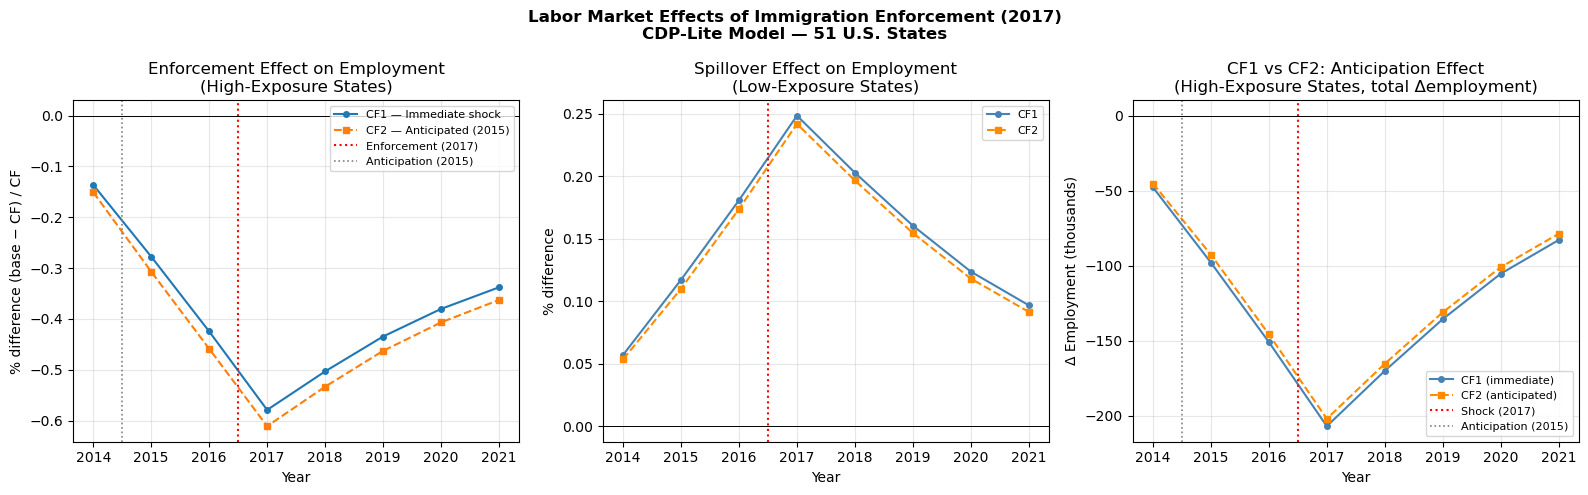

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Employment effect in high-exposure states (CF1 vs CF2)  
ax = axes[0]
for label, col, color, ls in [
    ("CF1 — Immediate shock",    "pct_cf1", "steelblue",  "-o"),
    ("CF2 — Anticipated (2015)", "pct_cf2", "darkorange", "--s"),
]:
    grp = results[results["high_exposure"] == 1].groupby("year")[col].mean()
    ax.plot(grp.index, grp.values * 100, ls, label=label, markersize=4)
ax.axvline(SHOCK_YR - 0.5, color="red",   ls=":", lw=1.5, label="Enforcement (2017)")
ax.axvline(ANTICIP_YR - 0.5, color="gray", ls=":", lw=1.2, label="Anticipation (2015)")
ax.axhline(0, color="black", lw=0.7)
ax.set_title("Enforcement Effect on Employment\n(High-Exposure States)")
ax.set_ylabel("% difference (base − CF) / CF")
ax.set_xlabel("Year"); ax.legend(fontsize=8); ax.grid(alpha=0.3)

# Plot 2: Spillover — employment change in LOW-exposure states 
ax = axes[1]
for label, col, color, ls in [
    ("CF1", "pct_cf1", "steelblue",  "-o"),
    ("CF2", "pct_cf2", "darkorange", "--s"),
]:
    grp = results[results["high_exposure"] == 0].groupby("year")[col].mean()
    ax.plot(grp.index, grp.values * 100, ls, label=label, markersize=4, color=color)
ax.axvline(SHOCK_YR - 0.5, color="red", ls=":", lw=1.5)
ax.axhline(0, color="black", lw=0.7)
ax.set_title("Spillover Effect on Employment\n(Low-Exposure States)")
ax.set_ylabel("% difference")
ax.set_xlabel("Year"); ax.legend(fontsize=8); ax.grid(alpha=0.3)

#Plot 3: CF1 vs CF2 — anticipation creates pre-trend migration  
ax = axes[2]
hi = results[results["high_exposure"] == 1].groupby("year")
ax.plot(hi["dL_cf1"].sum().index,
        hi["dL_cf1"].sum().values / 1e3, "-o", color="steelblue",
        label="CF1 (immediate)", markersize=4)
ax.plot(hi["dL_cf2"].sum().index,
        hi["dL_cf2"].sum().values / 1e3, "--s", color="darkorange",
        label="CF2 (anticipated)", markersize=4)
ax.axvline(SHOCK_YR - 0.5,   color="red",  ls=":", lw=1.5, label="Shock (2017)")
ax.axvline(ANTICIP_YR - 0.5, color="gray", ls=":", lw=1.2, label="Anticipation (2015)")
ax.axhline(0, color="black", lw=0.7)
ax.set_title("CF1 vs CF2: Anticipation Effect\n(High-Exposure States, total Δemployment)")
ax.set_ylabel("Δ Employment (thousands)")
ax.set_xlabel("Year"); ax.legend(fontsize=8); ax.grid(alpha=0.3)

plt.suptitle("Labor Market Effects of Immigration Enforcement (2017)\n"
             "CDP-Lite Model — 51 U.S. States", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig("cdp_results.png", dpi=150, bbox_inches="tight")
plt.show()

In [76]:
summary_dL = (res_all.groupby(["channel","year","high_exposure"])["dL"]
              .sum().div(1000).round(1))
print(summary_dL.to_string())

summary_pct = (res_all.groupby(["channel","year","high_exposure"])["pct"]
               .mean().mul(100).round(2))
print(summary_pct.to_string())

# Pivot so we can subtract channel-by-channel for each (year,state)
wide = res_all.pivot_table(index=["year","state_fips"], columns="channel", values="dL").reset_index()

wide["interaction"] = wide["total"] - (wide["wage_only"] + wide["fear_only"])

# Attach exposure labels
expo = pd.DataFrame({"state_fips": states, "high_exposure": [int(x) for x in high_idx]})
wide = wide.merge(expo, on="state_fips", how="left")

print("\n=== Interaction (nonlinearity) in thousands ===")
print(wide.groupby(["year","high_exposure"])["interaction"].sum().div(1000).round(2).to_string())

channel    year  high_exposure
fear_only  2014  0                 69.5
                 1                -69.5
           2015  0                142.3
                 1               -142.3
           2016  0                219.0
                 1               -219.0
           2017  0                300.2
                 1               -300.2
           2018  0                284.7
                 1               -284.7
           2019  0                270.1
                 1               -270.1
           2020  0                256.3
                 1               -256.3
           2021  0                243.2
                 1               -243.2
total      2014  0                 47.8
                 1                -47.8
           2015  0                 97.9
                 1                -97.9
           2016  0                150.9
                 1               -150.9
           2017  0                207.0
                 1               -207.0
         

=== Table 1: Aggregate Effects ===
         High-Exposure             Low-Exposure       
     $\Delta L$ (000s) \% chg $\Delta L$ (000s) \% chg
Year                                                  
2014             -47.8  -0.14              47.8   0.06
2015             -97.9  -0.28              97.9   0.12
2016            -150.9  -0.42             150.9   0.18
2017            -207.0  -0.58             207.0   0.25
2018            -170.1  -0.50             170.1   0.20
2019            -135.6  -0.43             135.6   0.16
2020            -105.4  -0.38             105.4   0.12
2021             -82.9  -0.34              82.9   0.10
Saved: table1_aggregate.tex



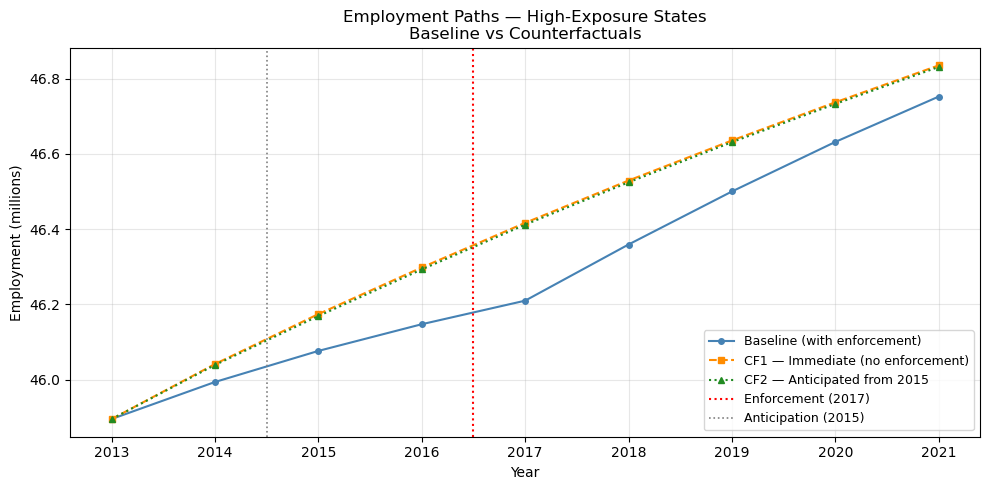

Saved: figure1_employment_paths.png



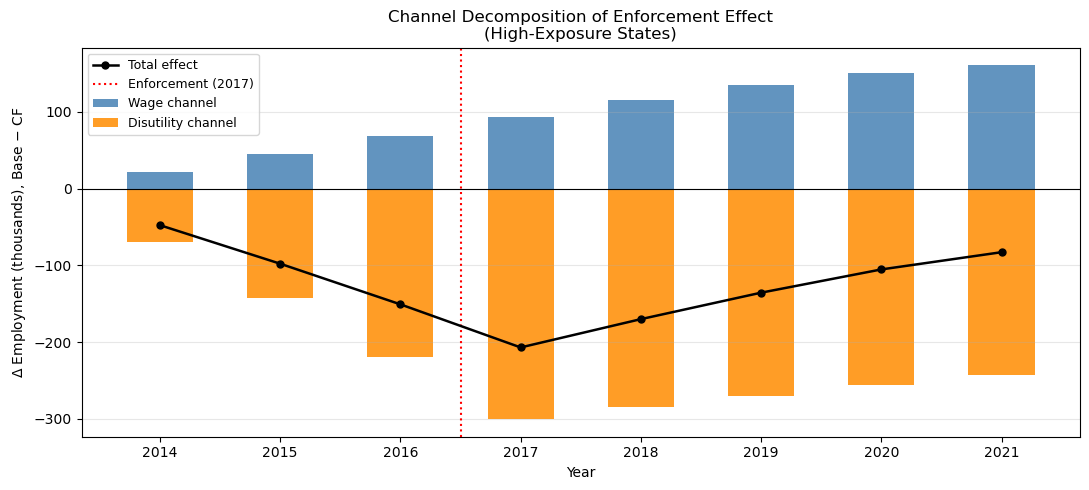

Saved: figure2_channel_decomp.png

=== Table 2: Anticipation Effects ===
      CF1 $\Delta L$ (000s)  CF2 $\Delta L$ (000s)  Anticipation Gap (000s)  CF1 \% chg  CF2 \% chg
Year                                                                                               
2014                  -47.8                  -45.2                      2.6       -0.14       -0.15
2015                  -97.9                  -92.7                      5.3       -0.28       -0.31
2016                 -150.9                 -145.7                      5.2       -0.42       -0.46
2017                 -207.0                 -202.0                      4.9       -0.58       -0.61
2018                 -170.1                 -165.4                      4.7       -0.50       -0.53
2019                 -135.6                 -131.1                      4.5       -0.43       -0.46
2020                 -105.4                 -101.0                      4.4       -0.38       -0.41
2021                  -82.9

In [77]:
hi_states_idx = [i for i, s in enumerate(states) if s in HIGH_EXPOSURE]

#Table 1: Aggregate Effects by year and exposure group  
hi_agg = results[results["high_exposure"] == 1].groupby("year")
lo_agg = results[results["high_exposure"] == 0].groupby("year")

t1 = pd.DataFrame({
    ("High-Exposure", "$\\Delta L$ (000s)"): (hi_agg["dL_cf1"].sum() / 1e3).round(1),
    ("High-Exposure", "\\% chg"):            (hi_agg["pct_cf1"].mean() * 100).round(2),
    ("Low-Exposure",  "$\\Delta L$ (000s)"): (lo_agg["dL_cf1"].sum() / 1e3).round(1),
    ("Low-Exposure",  "\\% chg"):            (lo_agg["pct_cf1"].mean() * 100).round(2),
})
t1.index.name = "Year"
t1.columns = pd.MultiIndex.from_tuples(t1.columns)

print("=== Table 1: Aggregate Effects ===")
print(t1.to_string())

latex_t1 = t1.to_latex(
    float_format="%.2f",
    caption=(
        "Aggregate employment effects of immigration enforcement by year and exposure group. "
        "$\\Delta L$ (thousands) is the total employment change (baseline $-$ CF1) and "
        "\\% chg is the average percent difference relative to the no-enforcement counterfactual "
        f"(CF1: immediate shock, $\\kappa={kappa}$, $\\nu={nu}$, $\\beta={beta}$). "
        "The enforcement shock begins in 2017."
    ),
    label="tab:aggregate_effects",
    bold_rows=True,
    escape=False,
    column_format="l" + "rr" * 2,
)
with open("table1_aggregate.tex", "w") as f:
    f.write(latex_t1)
print("Saved: table1_aggregate.tex\n")


# ── Figure 1: Employment Paths — Baseline vs CF1 vs CF2 ───────────────────────
L_hi_base = [L_base[y][hi_states_idx].sum() / 1e6 for y in YEARS]
L_hi_cf1  = [L_cf1[y][hi_states_idx].sum()  / 1e6 for y in YEARS]
L_hi_cf2  = [L_cf2[y][hi_states_idx].sum()  / 1e6 for y in YEARS]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(YEARS, L_hi_base, "-o",  color="steelblue",   label="Baseline (with enforcement)", markersize=4)
ax.plot(YEARS, L_hi_cf1,  "--s", color="darkorange",  label="CF1 — Immediate (no enforcement)", markersize=4)
ax.plot(YEARS, L_hi_cf2,  ":^",  color="forestgreen", label="CF2 — Anticipated from 2015", markersize=4)
ax.axvline(SHOCK_YR   - 0.5, color="red",  ls=":", lw=1.5, label="Enforcement (2017)")
ax.axvline(ANTICIP_YR - 0.5, color="gray", ls=":", lw=1.2, label="Anticipation (2015)")
ax.set_xlabel("Year")
ax.set_ylabel("Employment (millions)")
ax.set_title("Employment Paths — High-Exposure States\nBaseline vs Counterfactuals")
ax.legend(fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figure1_employment_paths.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: figure1_employment_paths.png\n")


# ── Figure 2: Channel Decomposition — stacked bars + total line ───────────────
hi_ch = (res_all[res_all["high_exposure"] == 1]
         .groupby(["channel", "year"])["dL"].sum().div(1e3).reset_index())

years_plot = sorted(hi_ch["year"].unique())
x          = np.arange(len(years_plot))
width      = 0.55

wage_vals  = hi_ch[hi_ch["channel"] == "wage_only"].set_index("year")["dL"].reindex(years_plot).values
fear_vals  = hi_ch[hi_ch["channel"] == "fear_only"].set_index("year")["dL"].reindex(years_plot).values
total_vals = hi_ch[hi_ch["channel"] == "total"].set_index("year")["dL"].reindex(years_plot).values

fig, ax = plt.subplots(figsize=(11, 5))
# Wage is positive, disutility is negative → bars go in opposite directions from 0
ax.bar(x, wage_vals, width, color="steelblue",  alpha=0.85, label="Wage channel")
ax.bar(x, fear_vals, width, color="darkorange", alpha=0.85, label="Disutility channel")
ax.plot(x, total_vals, "-o", color="black", lw=1.8, markersize=5, label="Total effect", zorder=5)

shock_x = list(years_plot).index(SHOCK_YR) - 0.5
ax.axvline(shock_x, color="red", ls=":", lw=1.5, label="Enforcement (2017)")
ax.axhline(0, color="black", lw=0.8)
ax.set_xticks(x)
ax.set_xticklabels(years_plot)
ax.set_xlabel("Year")
ax.set_ylabel("$\\Delta$ Employment (thousands), Base $-$ CF")
ax.set_title("Channel Decomposition of Enforcement Effect\n(High-Exposure States)")
ax.legend(fontsize=9)
ax.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig("figure2_channel_decomp.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: figure2_channel_decomp.png\n")


# ── Table 2: Anticipation Effects — CF1 vs CF2 ───────────────────────────────
hi = results[results["high_exposure"] == 1].groupby("year")

t2 = pd.DataFrame({
    "CF1 $\\Delta L$ (000s)":       (hi["dL_cf1"].sum() / 1e3).round(1),
    "CF2 $\\Delta L$ (000s)":       (hi["dL_cf2"].sum() / 1e3).round(1),
    "Anticipation Gap (000s)":      ((hi["dL_cf2"].sum() - hi["dL_cf1"].sum()) / 1e3).round(1),
    "CF1 \\% chg":                  (hi["pct_cf1"].mean() * 100).round(2),
    "CF2 \\% chg":                  (hi["pct_cf2"].mean() * 100).round(2),
})
t2.index.name = "Year"

print("=== Table 2: Anticipation Effects ===")
print(t2.to_string())

latex_t2 = t2.to_latex(
    float_format="%.2f",
    caption=(
        "Anticipation effects of immigration enforcement on high-exposure states. "
        "CF1 assumes workers learn of the shock at enforcement (2017); "
        "CF2 assumes workers anticipate from 2015. "
        "The anticipation gap (CF2 $-$ CF1) captures additional pre-migration due to "
        "forward-looking behavior "
        f"($\\kappa={kappa}$, $\\nu={nu}$, $\\beta={beta}$)."
    ),
    label="tab:anticipation_effects",
    bold_rows=True,
    escape=False,
    column_format="l" + "r" * 5,
)
with open("table2_anticipation.tex", "w") as f:
    f.write(latex_t2)
print("Saved: table2_anticipation.tex")

In [78]:
#TODO: stratify by worker-types (e.g. low-education vs high-education) if data allows, to see if enforcement had differential effects on different groups of workers.